In [1]:
import torch
import cv2, os
import matplotlib.pyplot as plt
import numpy as np
import pickle
from tqdm import tqdm

from utils import get_image_filepaths

In [2]:
%cd ..

/home/suetin/Projects/VSCode/UltrasoundCardiacReconstruction/HeartReconstruction


In [3]:
from src.scripts.models.U3plus import unet3plus
from src.scripts.models.U2Net import U2Net 
from src.scripts.DataLoaders import HeartLoader

In [4]:
# model_name = 'Unet3plus_1'  # 'u2net-cardio_segmentation'
# model_saved_dir = "results/Unet3+"
model_name = 'u2net-cardio_segmentation_1'
model_saved_dir = 'results/U2Net'

loss_path = F"{model_saved_dir}/{model_name}_loss.txt"
model_path = F"{model_saved_dir}/{model_name}.pt"  # _best

# with open(loss_path, 'rb') as f:
#   losses = pickle.load(f)

# model = unet3plus().cuda()
model = U2Net().cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [5]:
format = '.png'

# train_path = "data/train/train"
test_path = "data/train/test"

img_test_paths = get_image_filepaths(os.path.join(test_path, "images"), format, as_mask=False)
msk_test_paths = get_image_filepaths(os.path.join(test_path, "masks"), format, as_mask=True)

test_dataset = HeartLoader(img_test_paths, msk_test_paths, image_size=(512, 512))

len(msk_test_paths)

625

In [6]:
def prepare_input(img):
    # 
    if img.shape != (512, 512, 3):
        img = cv2.resize(img, (512, 512))

    img = img / 255
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, 0)
    img = img.astype(np.float32)
    img = torch.from_numpy(img).cuda()

    return img

def prepare_output(pred):
    if len(pred) > 1:
        pred = pred[-1]
    if pred.ndim == 4:
        pred = pred[0]

    pred = pred.cpu().detach().numpy()
    pred = sigmoid(pred)
    return np.transpose(pred, (1, 2, 0))

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [7]:
imgage = cv2.cvtColor(cv2.imread(img_test_paths[0]), cv2.COLOR_BGR2RGB)
new_img = prepare_input(imgage)
print(new_img.shape)

msk = cv2.imread(msk_test_paths[0], 0)
msk = np.where(msk == 255, 255, 0)

pred = model(new_img)[-1]
pred = prepare_output(pred)
pred.shape

torch.Size([1, 3, 512, 512])


(512, 512, 1)

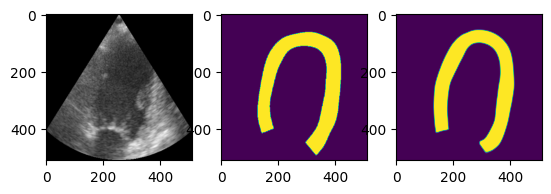

In [8]:
plt.subplot(131)
plt.imshow(imgage)
plt.subplot(132)
plt.imshow(msk)
plt.subplot(133)
plt.imshow(pred)

(944, 1392, 3)


[mjpeg @ 0x5fb4230aeac0] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42188ba40] unable to decode APP fields: Invalid data found when processing input


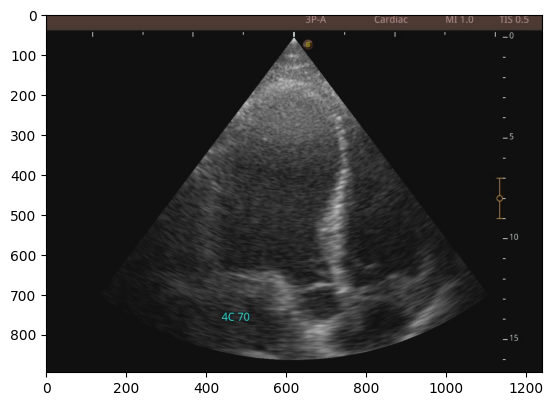

In [9]:
video_name = 'data/temporary/20240708_101231366.avi'

cap = cv2.VideoCapture(video_name)
# cap.set(2, frame_no);
ret, frame = cap.read()
print(frame.shape)
plt.imshow(frame[50:, 150:, :])

In [10]:
new_img = prepare_input(frame[50:, 150:, :])
print(new_img.shape)
pred = model(new_img)[-1]
pred = prepare_output(pred)
pred.shape

torch.Size([1, 3, 512, 512])


(512, 512, 1)

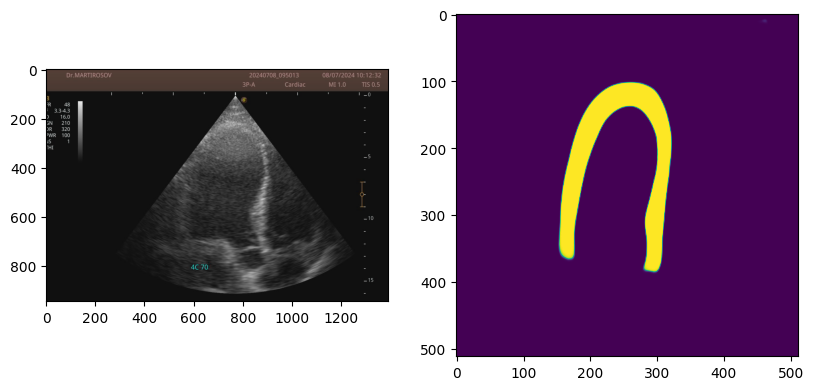

In [11]:
plt.figure(figsize=(15, 8))
plt.subplot(131)
plt.imshow(frame)
plt.subplot(132)
plt.imshow(pred)

In [12]:
51+60+43+4000+100

4254

## Find the worst predictions in test

In [13]:
from src.scripts.losses import DiceBCELoss

In [14]:
device = 'cuda:0'

# Test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=2)
# Loss func
DBCE = DiceBCELoss()

losses = {}
test_loss = 0.
model.eval()
with torch.no_grad():
  for i in tqdm(range(len(test_dataloader))):
    # input, target = next(iter(test_dataloader))
    input, target = test_dataset[i]
    input = torch.from_numpy(np.expand_dims(input, 0))
    target = torch.from_numpy(target)
    # print(input.shape, target.shape)
    out = model(input.to(device))[-1]
    curr_loss = DBCE(out, target.to(device)).item() / len(test_dataloader)
    test_loss += curr_loss

    losses[f'{i}'] = curr_loss


print(test_loss)

100%|██████████| 625/625 [00:31<00:00, 19.86it/s]

0.4332165871143343


In [15]:
import pandas as pd

df = pd.Series(losses.values(), index=losses.keys())
df.sort_values().index

Index(['297', '254', '380', '334', '419', '238', '373', '61', '48', '155',
       ...
       '406', '455', '377', '398', '492', '613', '218', '296', '543', '151'],
      dtype='object', length=625)

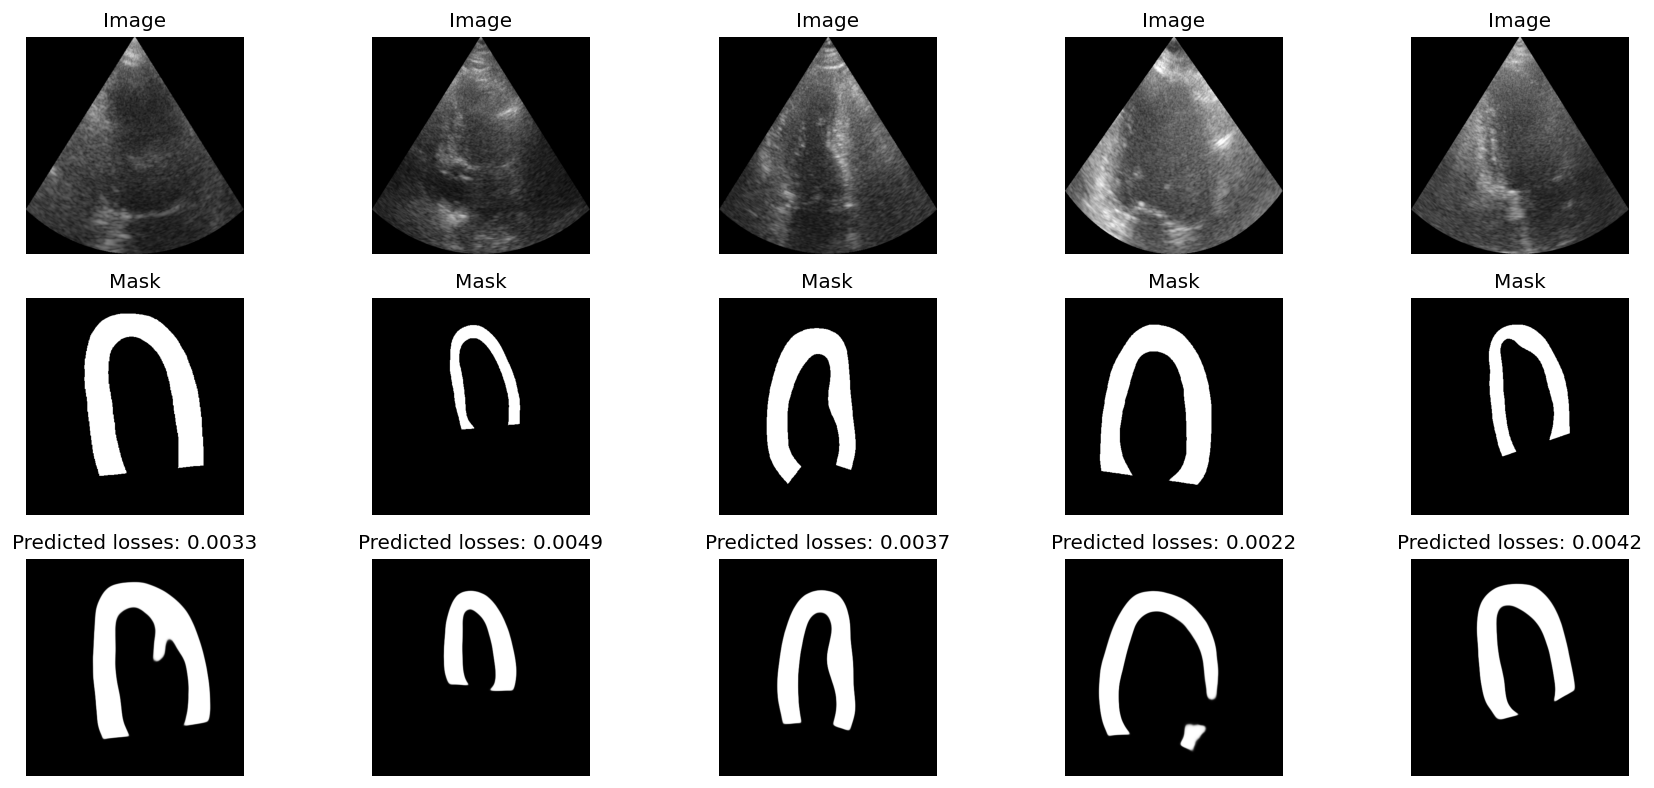

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(18, 8), dpi=120)

for j, i in enumerate(['218', '151', '296', '602', '543']):
    i = int(i)

    input, target = test_dataset[i]
    
    ax[0, j].set_title('Image')
    ax[0, j].set_axis_off()
    ax[0, j].imshow(np.transpose(input, (1, 2, 0)))

    ax[1, j].set_title('Mask')
    ax[1, j].set_axis_off()
    ax[1, j].imshow(np.transpose(target, (1, 2, 0)), 'gray')

    input = torch.from_numpy(np.expand_dims(input, 0))
    pred = model(input.to(device))[-1]
    pred = prepare_output(pred)
    ax[2, j].set_title(f'Predicted losses: {round(losses[f"{i}"], 4)}')
    ax[2, j].set_axis_off()
    ax[2, j].imshow(pred, 'gray')

plt.show()

## Make gif with predictions of .avi video

In [17]:
import imageio

 
gif = cv2.VideoCapture(video_name)
fps = gif.get(cv2.CAP_PROP_FPS)
frames = []

# with imageio.get_writer('/results/U2Net/prediction.gif', mode='I') as writer:   # data/temporary/20240708_101231366.avi'
    
while True:
    ret, frame = gif.read()
    if ret:
        # new_frame = np.zeros((256, 128))   # Original_img - Predicted mask

        im = frame[50:, 150:, :]
        image = cv2.resize(im, (128, 128), cv2.INTER_LINEAR)
        # Save original image to output frame
        # new_frame[:128, :, :] = im
        inputs = prepare_input(im)
        pred = model(inputs)[-1]
        pred = prepare_output(pred)
        pred = cv2.cvtColor(pred, cv2.COLOR_GRAY2RGB)
        pred = (pred * 255).astype('uint8')
        pred = cv2.resize(pred, (128, 128), cv2.INTER_LINEAR)
        # 
        new_frame = np.concat([image, pred], axis=1)
        # break
        frames.append(new_frame)    
    else:
        break
        

imageio.mimsave('results/test_movie_1.gif', frames, format='GIF', fps=fps)

[mjpeg @ 0x5fb42f9a7c80] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fields: Invalid data found when processing input
[mjpeg @ 0x5fb42f9ab280] unable to decode APP fiel